In [1]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [2]:
data = pd.read_csv("Ligue_1_22_23.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [3]:
cmap_lst = ['#131313', '#24a8ff', '#0d4163'] 
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 

In [4]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.matchId==next_actions.matchId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['matchId' ] = nex.matchId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team_name','playerName','h_a']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['playerName' ]= nex.playerName
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['matchId','period','action_id']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [5]:
data = add_carries(data)

In [6]:
data_andre = data[data['playerId'] == 366379]

In [7]:
data_andre

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,...,subOn,subOff,defensiveThird,midThird,finalThird,pos,isOwnGoal,team_name,time_seconds,action_id
20940,NaN,NaN,NaN,NaN,NaN,613.0,a,52.32,62.72,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nice,26.5,20940
20955,NaN,NaN,NaN,NaN,NaN,613.0,a,45.72,57.44,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nice,52.5,20955
20968,NaN,NaN,NaN,NaN,NaN,613.0,a,35.88,38.56,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nice,124.5,20968
20975,NaN,NaN,NaN,NaN,NaN,613.0,a,41.52,67.76,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nice,134.0,20975
20993,NaN,NaN,NaN,NaN,NaN,613.0,a,72.84,48.00,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nice,194.5,20993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827156,685.0,2.547975e+09,381.0,36.0,13.0,613.0,a,75.60,57.04,36.0,...,False,False,False,True,False,True,NaN,Nice,2173.0,827156
827162,691.0,2.547975e+09,387.0,36.0,33.0,613.0,a,52.08,70.72,36.0,...,False,False,False,False,False,False,NaN,Nice,2193.0,827162
827170,699.0,2.547976e+09,392.0,36.0,50.0,613.0,a,32.28,49.68,36.0,...,False,False,True,False,False,True,NaN,Nice,2210.0,827170
827186,715.0,2.547977e+09,405.0,37.0,41.0,613.0,a,54.48,45.28,37.0,...,False,False,False,False,True,True,NaN,Nice,2261.0,827186


In [8]:
data_dribbles = data_andre[data_andre['type'] == 'TakeOn']

In [9]:
data_tackles = data_andre[data_andre['type'] == 'Tackle']

In [10]:
tackles_won = data_tackles[data_tackles['tackleWon'] == True]
tackles_lost = data_tackles[data_tackles['tackleLost'] == True]

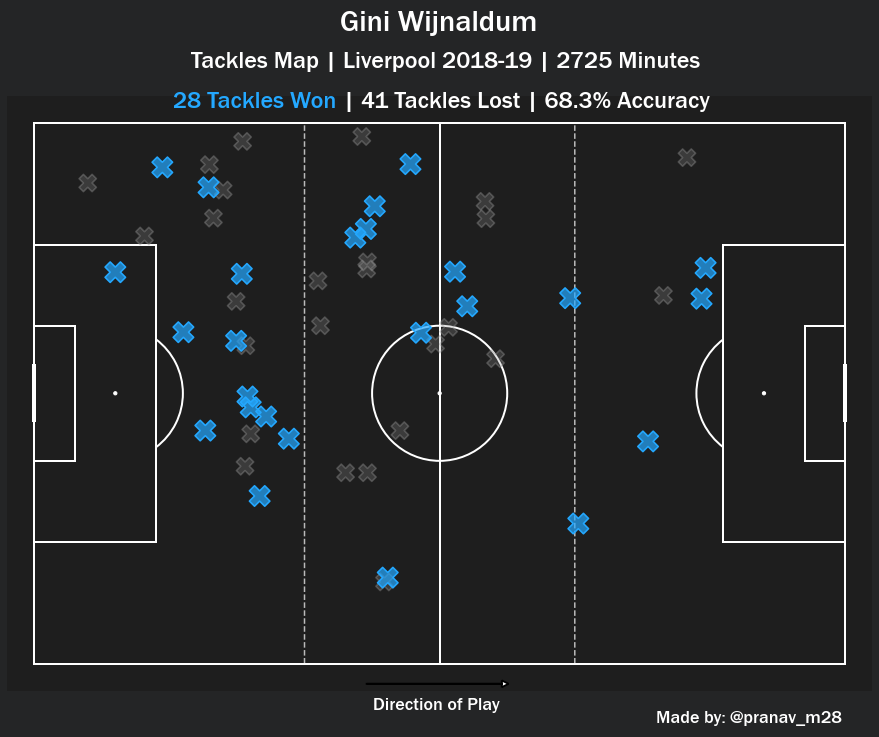

In [11]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)


#Plotting Tackles Won

pitch.scatter(tackles_won.x, tackles_won.y, s=420,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(tackles_won.x, tackles_won.y, s=420,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)

#Plotting Tackles Lost

pitch.scatter(tackles_lost.x, tackles_lost.y, s=300,
              marker='X', edgecolors='#949494', c='none', zorder=3, ax=ax , alpha=0.4 , ls='-' , lw=1.6)

pitch.scatter(tackles_lost.x, tackles_lost.y, s=300,
              marker='X', edgecolors='none', c='#949494', zorder=3, ax=ax , alpha=0.25)




plt.gca().invert_yaxis()

fig_text(
    0.512, 0.945, "<Gini Wijnaldum>", font='Franklin Gothic Medium' , size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Tackles Map | Liverpool 2018-19 | 2725 Minutes",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)




fig_text(
    0.514, 0.851,
    "<28 Tackles Won> | 41 Tackles Lost | 68.3% Accuracy",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color" : "#24a8ff"}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)   


#plt.savefig("Gini 18-19 Tackling.png" , dpi=300, bbox_inches='tight')

In [12]:
tackles_won['x'].count()

25

In [13]:
tackles_lost['x'].count()

26

In [14]:
41/57

0.7192982456140351

In [15]:
data_dribbles

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,...,subOn,subOff,defensiveThird,midThird,finalThird,pos,isOwnGoal,team_name,time_seconds,action_id
21448,33.0,2.443322e+09,935.0,1.0,18.0,613.0,a,57.12,61.12,1.0,...,False,False,False,False,False,False,NaN,Nice,78.0,21448
21504,89.0,2.443326e+09,937.0,3.0,18.0,613.0,a,94.32,41.36,3.0,...,False,False,False,False,False,False,NaN,Nice,198.0,21504
21708,293.0,2.443222e+09,166.0,15.0,6.0,613.0,a,45.36,67.04,15.0,...,False,False,False,False,False,False,NaN,Nice,906.0,21708
22201,786.0,2.443243e+09,442.0,44.0,26.0,613.0,a,58.08,64.16,44.0,...,False,False,False,False,False,False,NaN,Nice,2666.0,22201
23028,1216.0,2.443277e+09,678.0,71.0,38.0,613.0,a,56.88,62.32,74.0,...,False,False,False,False,False,False,NaN,Nice,4298.0,23028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787116,649.0,2.541679e+09,515.0,33.0,30.0,613.0,a,118.20,58.96,33.0,...,False,False,False,False,False,False,NaN,Nice,2010.0,787116
787862,907.0,2.541684e+09,582.0,49.0,2.0,613.0,a,89.64,73.60,50.0,...,False,False,False,False,False,False,NaN,Nice,2942.0,787862
800754,14.0,2.544435e+09,10.0,0.0,17.0,613.0,h,62.04,70.16,0.0,...,False,False,False,False,False,False,NaN,Nice,17.0,800754
802018,919.0,2.544489e+09,472.0,53.0,41.0,613.0,h,65.04,46.64,55.0,...,False,False,False,False,False,False,NaN,Nice,3221.0,802018


In [16]:
dribbles_won = data_dribbles[data_dribbles['dribbleWon'] == True]
dribbles_lost = data_dribbles[data_dribbles['dribbleLost'] == True]

In [17]:
dribbles_won['x'].count()

46

In [18]:
dribbles_lost['x'].count()

31

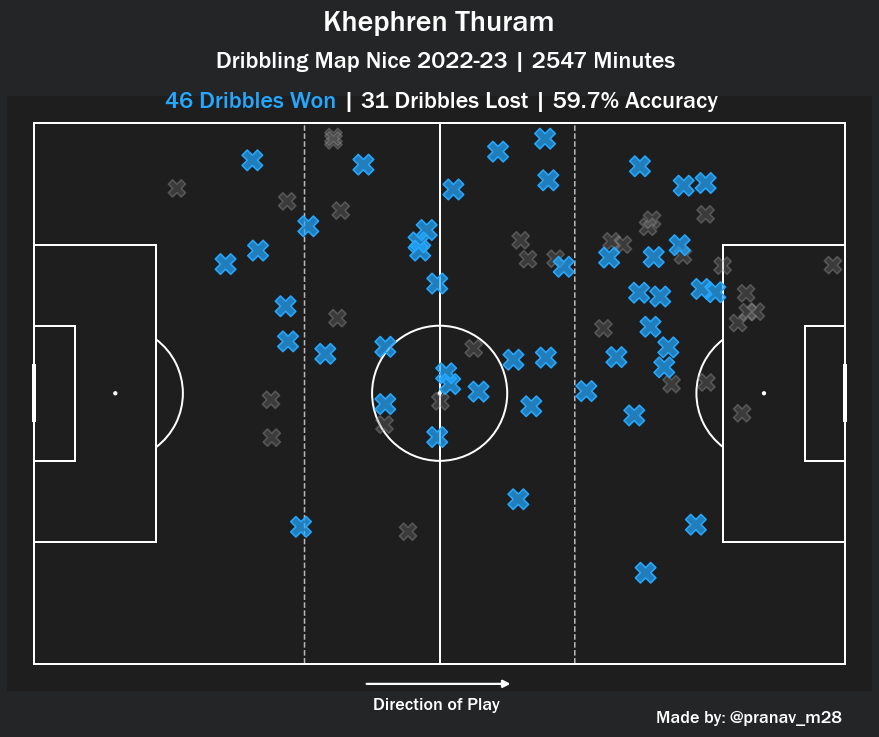

In [61]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)


#Plotting TakeOns Won

pitch.scatter(dribbles_won.x, dribbles_won.y, s=420,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(dribbles_won.x, dribbles_won.y, s=420,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)

#Plotting TakeOns Lost

pitch.scatter(dribbles_lost.x, dribbles_lost.y, s=300,
              marker='X', edgecolors='#949494', c='none', zorder=3, ax=ax , alpha=0.4 , ls='-' , lw=1.6)

pitch.scatter(dribbles_lost.x, dribbles_lost.y, s=300,
              marker='X', edgecolors='none', c='#949494', zorder=3, ax=ax , alpha=0.25)




plt.gca().invert_yaxis()

fig_text(
    0.512, 0.945, "<Khephren Thuram>", font='Franklin Gothic Medium' , size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Dribbling Map Nice 2022-23 | 2547 Minutes",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)




fig_text(
    0.514, 0.851,
    "<46 Dribbles Won> | 31 Dribbles Lost | 59.7% Accuracy",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color" : "#24a8ff"}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)   


#plt.savefig("Thuram 22-23 Dribbling.png" , dpi=300, bbox_inches='tight')

In [20]:
dribbles_won['x'].count()

46

In [58]:
dribbles_lost['x'].count()

31

In [59]:
46/77

0.5974025974025974

In [21]:
recov = data_andre[data_andre['ballRecovery'] == True]

In [22]:
recov

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,...,subOn,subOff,defensiveThird,midThird,finalThird,pos,isOwnGoal,team_name,time_seconds,action_id
22171,756.0,2.443242e+09,422.0,42.0,52.0,613.0,a,77.16,78.48,42.0,...,False,False,False,False,False,False,NaN,Nice,2572.0,22171
22753,941.0,2.443263e+09,514.0,50.0,32.0,613.0,a,45.36,69.76,53.0,...,False,False,False,False,False,False,NaN,Nice,3032.0,22753
23406,1594.0,2.443294e+09,917.0,93.0,23.0,613.0,a,46.92,30.80,96.0,...,False,False,False,False,False,False,NaN,Nice,5603.0,23406
35437,47.0,2.446205e+09,29.0,2.0,8.0,613.0,h,53.16,23.12,2.0,...,False,False,False,False,False,False,NaN,Nice,128.0,35437
35480,90.0,2.446208e+09,55.0,6.0,44.0,613.0,h,19.20,50.80,6.0,...,False,False,False,False,False,False,NaN,Nice,404.0,35480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801302,562.0,2.544465e+09,281.0,33.0,26.0,613.0,h,50.04,32.08,33.0,...,False,False,False,False,False,False,NaN,Nice,2006.0,801302
802008,909.0,2.544489e+09,463.0,53.0,8.0,613.0,h,38.16,54.96,55.0,...,False,False,False,False,False,False,NaN,Nice,3188.0,802008
802299,1200.0,2.544500e+09,627.0,73.0,1.0,613.0,h,50.16,59.28,75.0,...,False,False,False,False,False,False,NaN,Nice,4381.0,802299
802548,1449.0,2.544510e+09,743.0,86.0,59.0,613.0,h,82.44,34.40,88.0,...,False,False,False,False,False,False,NaN,Nice,5219.0,802548


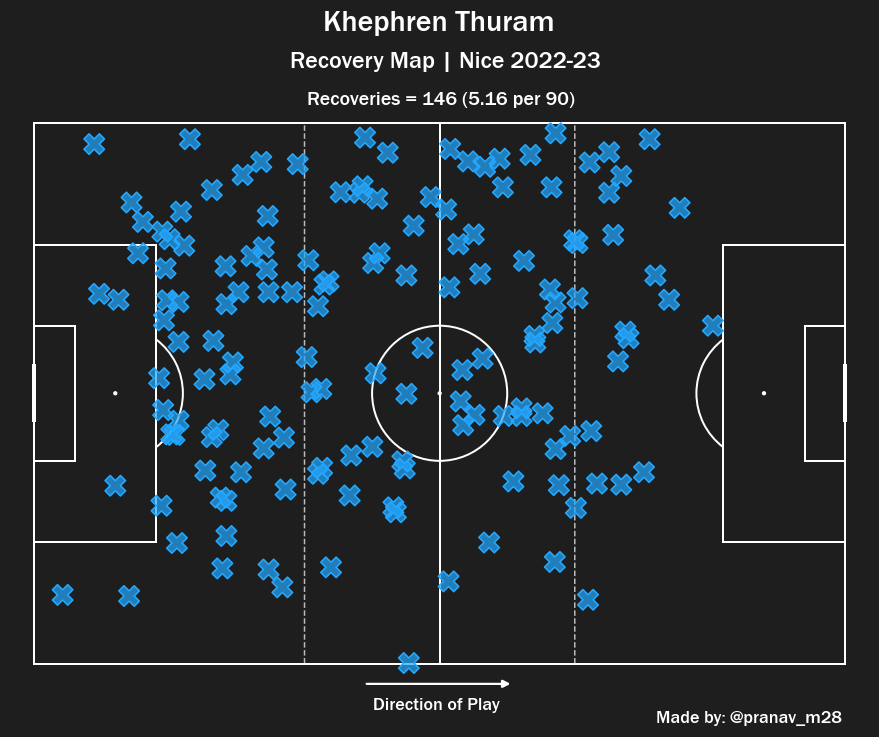

In [63]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#1e1e1e')
ax.patch.set_facecolor('#1e1e1e')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True , line_zorder=2)

pitch.draw(ax=ax)

#bin_statistic = pitch.bin_statistic(recov.x, recov.y, statistic='count', bins=(25, 25))
#bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
#pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#000000' , alpha=0.88)

pitch.scatter(recov.x, recov.y, s=420,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(recov.x, recov.y, s=420,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)




plt.gca().invert_yaxis()


fig_text(
    0.512, 0.945, "<Khephren Thuram>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Recovery Map | Nice 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.514, 0.851,
    "Recoveries = 146 (5.16 per 90)",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.514, 0.851,
    "<>",
    size=13,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)  

#plt.savefig('Thuram Recoveries.png' , dpi=300 , bbox_inches='tight')

In [24]:
recov['x'].count()

146

In [25]:
213/32.1

6.635514018691588

In [26]:
73/105

0.6952380952380952

In [27]:
##Passing Vizzes
data_passes = data_andre[data_andre['type'] == 'Pass']

In [28]:
data_passes

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,...,subOn,subOff,defensiveThird,midThird,finalThird,pos,isOwnGoal,team_name,time_seconds,action_id
21428,13.0,2.443215e+09,12.0,0.0,27.0,613.0,a,54.84,68.48,0.0,...,False,False,True,False,False,True,NaN,Nice,27.0,21428
21437,22.0,2.443215e+09,22.0,0.0,53.0,613.0,a,45.96,58.88,0.0,...,False,False,True,False,False,True,NaN,Nice,53.0,21437
21449,34.0,2.443215e+09,31.0,1.0,20.0,613.0,a,58.20,75.60,1.0,...,False,False,False,True,False,True,NaN,Nice,80.0,21449
21467,52.0,2.443215e+09,37.0,2.0,7.0,613.0,a,36.00,51.20,2.0,...,False,False,True,False,False,True,NaN,Nice,127.0,21467
21471,56.0,2.443215e+09,41.0,2.0,15.0,613.0,a,42.96,61.20,2.0,...,False,False,False,True,False,True,NaN,Nice,135.0,21471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827065,594.0,2.547968e+09,328.0,31.0,15.0,613.0,a,65.64,67.60,31.0,...,False,False,False,True,False,True,NaN,Nice,1875.0,827065
827106,635.0,2.547970e+09,354.0,33.0,20.0,613.0,a,29.16,60.56,33.0,...,False,False,True,False,False,True,NaN,Nice,2000.0,827106
827156,685.0,2.547975e+09,381.0,36.0,13.0,613.0,a,75.60,57.04,36.0,...,False,False,False,True,False,True,NaN,Nice,2173.0,827156
827170,699.0,2.547976e+09,392.0,36.0,50.0,613.0,a,32.28,49.68,36.0,...,False,False,True,False,False,True,NaN,Nice,2210.0,827170


In [29]:
data_succ = data_passes[data_passes['outcomeType'] == 'Successful']
data_unsucc = data_passes[data_passes['outcomeType'] == 'Unsuccessful']

In [30]:
data_succ_prog = data_succ.reset_index()
data_unsucc_prog = data_unsucc.reset_index()
data_succ_prog['beginning'] = np.sqrt(np.square(120-data_succ_prog['x']) + np.square(40 - data_succ_prog['y']))
data_succ_prog['end'] = np.sqrt(np.square(120 - data_succ_prog['endX']) + np.square(40 - data_succ_prog['endY']))

data_succ_prog['progressive'] = [(data_succ_prog['end'][x]) / (data_succ_prog['beginning'][x]) < .75 for x in range(len(data_succ_prog.beginning))]
data_succ_prog = data_succ_prog[data_succ_prog['progressive'] == True]

In [31]:
data_carries = data_andre[data_andre['type'] == 'Carry']

data_carries_succ = data_carries[data_carries['outcomeType'] == 'Successful']
data_carries_unsucc = data_carries[data_carries['outcomeType'] == 'Unsuccessful']

data_carries_succ_prog = data_carries_succ.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()

data_carries_succ_prog['beginning'] = np.sqrt(np.square(120-data_carries_succ_prog['x']) + np.square(40 - data_carries_succ_prog['y']))
data_carries_succ_prog['end'] = np.sqrt(np.square(120 - data_carries_succ_prog['endX']) + np.square(40 - data_carries_succ_prog['endY']))

data_carries_succ_prog['progressive'] = [(data_carries_succ_prog['end'][x]) / (data_carries_succ_prog['beginning'][x]) < .75 for x in range(len(data_carries_succ_prog.beginning))]
data_carries_succ_prog = data_carries_succ_prog[data_carries_succ_prog['progressive'] == True]

In [32]:
data_carries_succ_prog['x'].count()

59

In [33]:
data_succ_prog = data_succ_prog[data_succ_prog['passCorner'] == False]

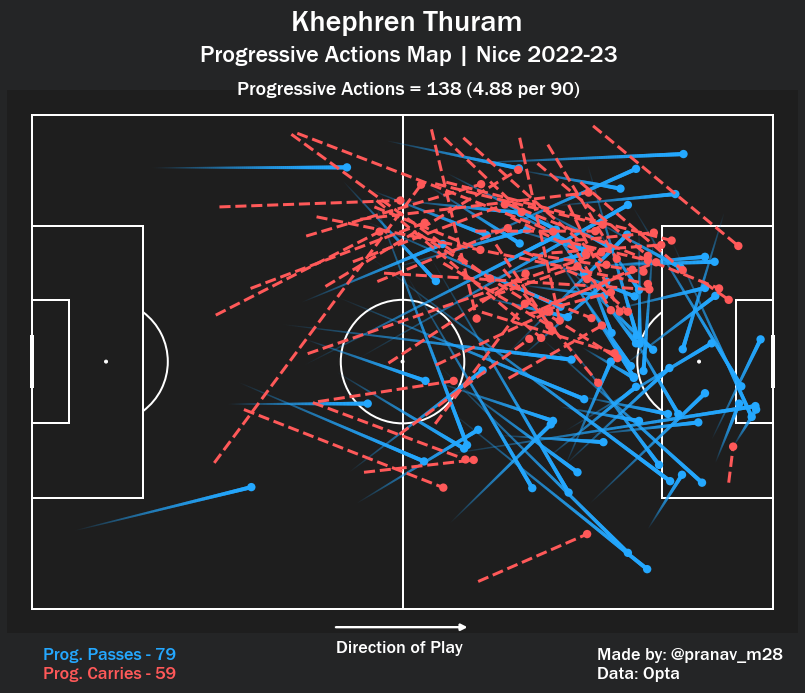

In [56]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 10),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

#Plotting Progressive Passes

lc1 = pitch.lines(data_succ_prog.x, data_succ_prog.y,
                  data_succ_prog.endX, data_succ_prog.endY,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#24a8ff', ax=ax)

pitch.scatter(data_succ_prog.endX, data_succ_prog.endY, s=70,
              marker='o', edgecolors='none', c='#24a8ff', zorder=2,
              label='goal', ax=ax , alpha=1)


#Plotting Progressive Carries

lc1 = pitch.lines(data_carries_succ_prog.x, data_carries_succ_prog.y,
                  data_carries_succ_prog.endX, data_carries_succ_prog.endY,ls='dashed',
                  lw=3, transparent=False, comet=False, label='completed passes',
                  color='#FF5959', ax=ax)

pitch.scatter(data_carries_succ_prog.endX, data_carries_succ_prog.endY, s=70,
              marker='o', edgecolors='none', c='#FF5959', zorder=2,
              label='goal', ax=ax , alpha=1)

plt.gca().invert_yaxis()


fig_text(
    0.516, 0.99, "<Khephren Thuram>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Progressive Actions Map | Nice 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.518, 0.892,
    "Progressive Actions = 138 (4.88 per 90)",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.250, 0.105, "<Prog. Passes - 79>\n<Prog. Carries - 59>", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#24a8ff'} , {"color": '#FF5959'}]
)

plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.115, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('Thuram Progressive Actions 22-23.png' , dpi=300 , bbox_inches='tight')


In [35]:
data_succ_prog['x'].count()

79

In [36]:
386/32.5

11.876923076923077

In [37]:
cmap_lst = ['#131313', '#24a8ff', '#0d4163'] 
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 

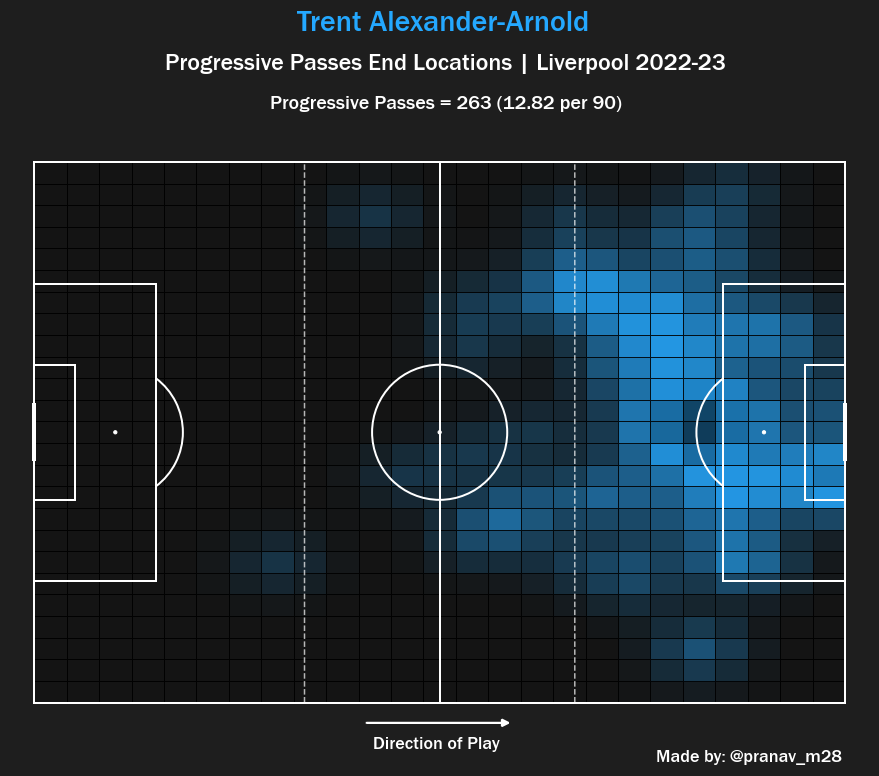

In [38]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#1e1e1e')
ax.patch.set_facecolor('#1e1e1e')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True , line_zorder=2)

pitch.draw(ax=ax)

bin_statistic = pitch.bin_statistic(data_succ_prog.endX, data_succ_prog.endY, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#000000' , alpha=0.88)

plt.gca().invert_yaxis()


fig_text(
    0.516, 0.99, "<Trent Alexander-Arnold>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#24a8ff'}]
)

fig_text(
    0.518, 0.941,
    "Progressive Passes End Locations | Liverpool 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.518, 0.892,
    "Progressive Passes = 263 (12.82 per 90)",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.514, 0.851,
    "<>",
    size=13,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)  

#plt.savefig('Andre Progressive Passes End Locations.png' , dpi=300 , bbox_inches='tight')



In [39]:
recov_mid = recov[(recov['x'] <= 80) & (recov['x'] >= 40)]

In [40]:
recov_mid['x'].count()

68

In [41]:
recov_def = recov[recov['x'] <= 40]

In [42]:
recov_def['x'].count()

57

In [43]:
data_andre['x_n'] = data_andre['x'].shift(-1)
data_andre['y_n'] = data_andre['y'].shift(-1)
data_andre['endX_n'] = data_andre['endX'].shift(-1)
data_andre['endY_n'] = data_andre['endY'].shift(-1)
data_andre['type_n'] = data_andre['type'].shift(-1)
data_andre['outcomeType_n'] = data_andre['outcomeType'].shift(-1)
recov_2 = data_andre[data_andre['type'] == 'BallRecovery']
succ_pass_afrecov = recov_2[recov_2['outcomeType_n'] == 'Successful']
succ_pass_afrecov_prog = succ_pass_afrecov.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()
succ_pass_afrecov_prog['beginning'] = np.sqrt(np.square(120-succ_pass_afrecov_prog['x_n']) + np.square(40 - succ_pass_afrecov_prog['y_n']))
succ_pass_afrecov_prog['end'] = np.sqrt(np.square(120 - succ_pass_afrecov_prog['endX_n']) + np.square(40 - succ_pass_afrecov_prog['endY_n']))

succ_pass_afrecov_prog['progressive'] = [(succ_pass_afrecov_prog['end'][x]) / (succ_pass_afrecov_prog['beginning'][x]) < .75 for x in range(len(succ_pass_afrecov_prog.beginning))]
succ_pass_afrecov_prog = succ_pass_afrecov_prog[succ_pass_afrecov_prog['progressive'] == True]

#Unsucc Passes

unsucc_pass_afrecov = recov_2[recov_2['outcomeType_n'] == 'Unsuccessful']
unsucc_pass_afrecov_prog = unsucc_pass_afrecov.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()
unsucc_pass_afrecov_prog['beginning'] = np.sqrt(np.square(120-unsucc_pass_afrecov_prog['x_n']) + np.square(40 - unsucc_pass_afrecov_prog['y_n']))
unsucc_pass_afrecov_prog['end'] = np.sqrt(np.square(120 - unsucc_pass_afrecov_prog['endX_n']) + np.square(40 - unsucc_pass_afrecov_prog['endY_n']))

unsucc_pass_afrecov_prog['progressive'] = [(unsucc_pass_afrecov_prog['end'][x]) / (unsucc_pass_afrecov_prog['beginning'][x]) < .75 for x in range(len(unsucc_pass_afrecov_prog.beginning))]
unsucc_pass_afrecov_prog = unsucc_pass_afrecov_prog[unsucc_pass_afrecov_prog['progressive'] == True]




C:\Users\91852\AppData\Local\Temp/ipykernel_1784/83920504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_andre['x_n'] = data_andre['x'].shift(-1)
C:\Users\91852\AppData\Local\Temp/ipykernel_1784/83920504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_andre['y_n'] = data_andre['y'].shift(-1)
C:\Users\91852\AppData\Local\Temp/ipykernel_1784/83920504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [44]:
unsucc_pass_afrecov['endX_n'].count()

23

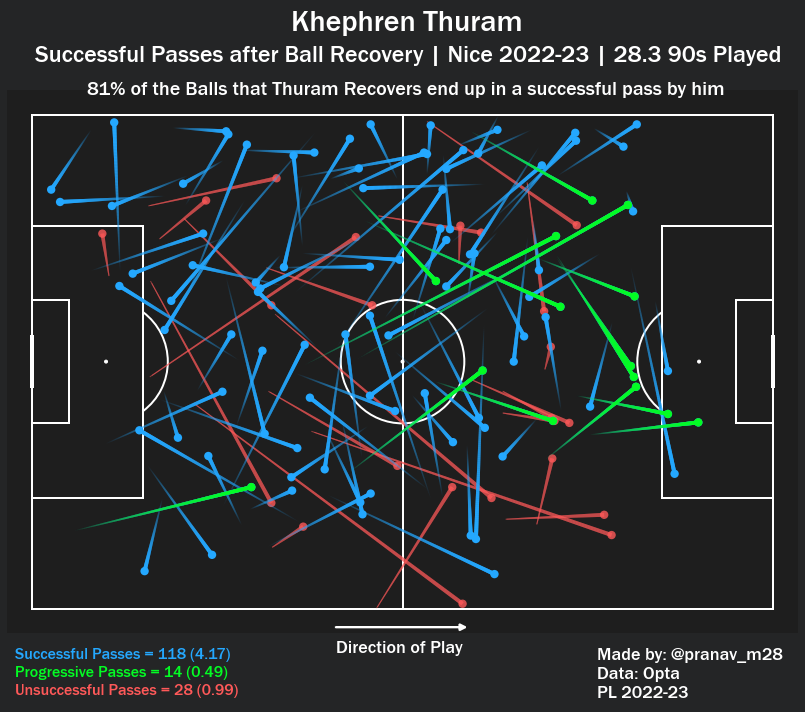

In [57]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 10),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

#Plotting Passes post Recovery

lc1 = pitch.lines(succ_pass_afrecov.x_n, succ_pass_afrecov.y_n,
                  succ_pass_afrecov.endX_n, succ_pass_afrecov.endY_n,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#24a8ff', ax=ax , ZORDER=3)

pitch.scatter(succ_pass_afrecov.endX_n, succ_pass_afrecov.endY_n, s=70,
              marker='o', edgecolors='none', c='#24a8ff', zorder=3,
              label='goal', ax=ax , alpha=1)

#Plotting Prog Passes post Recovery

lc1 = pitch.lines(succ_pass_afrecov_prog.x_n, succ_pass_afrecov_prog.y_n,
                  succ_pass_afrecov_prog.endX_n, succ_pass_afrecov_prog.endY_n,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#03fc24', ax=ax, ZORDER=4)

pitch.scatter(succ_pass_afrecov_prog.endX_n, succ_pass_afrecov_prog.endY_n, s=70,
              marker='o', edgecolors='none', c='#03fc24', zorder=4,
              label='goal', ax=ax , alpha=1)


#Plotting Unsuccessful Passes post Recovery

lc1 = pitch.lines(unsucc_pass_afrecov.x_n, unsucc_pass_afrecov.y_n,
                  unsucc_pass_afrecov.endX_n, unsucc_pass_afrecov.endY_n,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#FF5959', ax=ax , alpha=0.5)

pitch.scatter(unsucc_pass_afrecov.endX_n, unsucc_pass_afrecov.endY_n, s=70,
              marker='o', edgecolors='none', c='#FF5959', zorder=1,
              label='goal', ax=ax , alpha=0.8)



plt.gca().invert_yaxis()


fig_text(
    0.516, 0.99, "<Khephren Thuram>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Successful Passes after Ball Recovery | Nice 2022-23 | 28.3 90s Played",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.518, 0.892,
    "81% of the Balls that Thuram Recovers end up in a successful pass by him ",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta\nPL 2022-23", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.265, 0.105, "<Successful Passes = 118 (4.17)>\n<Progressive Passes = 14 (0.49)>\n<Unsuccessful Passes = 28 (0.99)>",
    font='Franklin Gothic Medium' ,size=16,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#24a8ff'} , {"color": '#03fc24'}
                                                                           , {"color" : "#FF5959"}]
)

plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.115, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('Thuram 22-23 post-Recovery pass map.png' , dpi=300 , bbox_inches='tight')

In [46]:
succ_pass_afrecov_prog['x'].count()

14

In [47]:
succ_pass_afrecov['x'].count()

118

In [48]:
unsucc_pass_afrecov['x'].count()

28

In [49]:
succ_pass_afrecov['x'].count()/(succ_pass_afrecov['x'].count() + unsucc_pass_afrecov['x'].count())

0.8082191780821918

In [50]:
152/193

0.7875647668393783

In [51]:
18/301

0.059800664451827246

In [52]:
18/32.3

0.5572755417956656

In [53]:
39/32.3

1.2074303405572757

data